In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt

# lya_fields.py

In [2]:
import numpy as np
import tensorflow as tf

# local modules
import grid
import lya_fields
import snapshot
from spectrum import gmlt_spec_od_grid

# define dataset paths
ds_path_rhob = "/native_fields/baryon_density"
ds_path_temp = "/native_fields/temperature"
ds_path_vx   = "/native_fields/velocity_x"
ds_path_vy   = "/native_fields/velocity_y"
ds_path_vz   = "/native_fields/velocity_z"

ds_path_nhi      = "/derived_fields/HI_number_density"
ds_path_tau_real = "/derived_fields/tau_real"
ds_path_tau_red  = "/derived_fields/tau_red"

filename = "../../../../../cscratch1/sd/jupiter/sim2_z3_FGPA_cgs.h5"
snap = snapshot.Snapshot(filename)

## Compute $n_\text{H I}$ (1024^2 grid)

In [3]:
# subsection shape
shape = [1, 1024, 1024]

rhob = snap.read_subfield(ds_path_rhob, shape)
temp = snap.read_subfield(ds_path_temp, shape)

In [4]:
# get the nhi grid
with tf.GradientTape(persistent=True) as tape:
    
#     tape.watch(rhob.field)
#     tape.watch(temp.field)

    nhi = lya_fields.set_nhi(snap, rhob, temp)

EOS duration: 6.572765350341797


In [5]:
#print("nhi's shape:", tf.shape(nhi.field))
dn_dr = tape.gradient(nhi.field, rhob.field)
dn_dt = tape.gradient(nhi.field, temp.field)

In [6]:
print("dn/dt's shape:", tf.shape(dn_dt))

dn/dt's shape: tf.Tensor([   1 1024 1024], shape=(3,), dtype=int32)


In [7]:
def print_minmax(t, name):
    '''
    Given a tensor t and its name, print t's minimum and maximum values.
    
    '''
    
    print(name + ' min:', np.amin(t))
    print(name + ' max:', np.amax(t))
    print('')

In [8]:
print_minmax(dn_dr, 'dn/dr')
print_minmax(dn_dt, 'dn/dt')
#print_minmax(dn_dr_j, 'dn/dr (jacobian)')

dn/dr min: 1.581567481102815e-14
dn/dr max: 1.8394840366090194e-10

dn/dt min: -2.1175986908998264e-18
dn/dt max: -1.3050108704419662e-20



## Look at the $\frac{dn}{d\rho}$ and $\frac{dn}{dT}$ fields

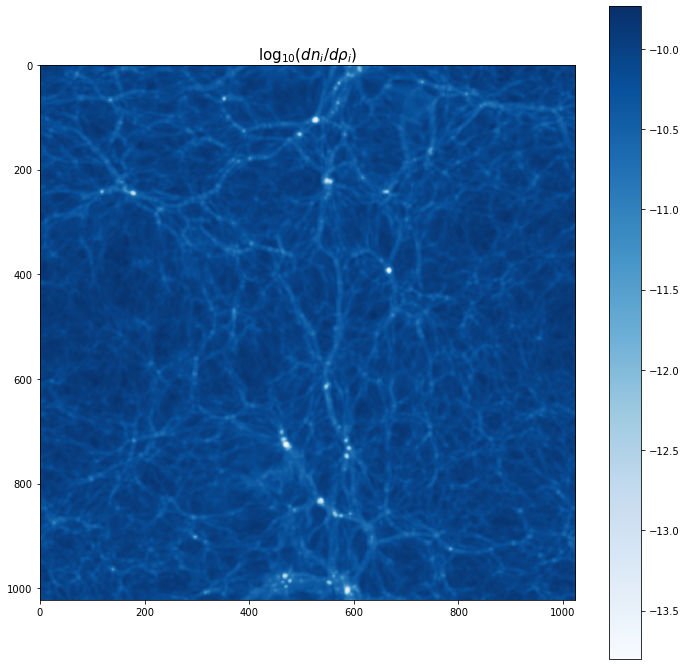

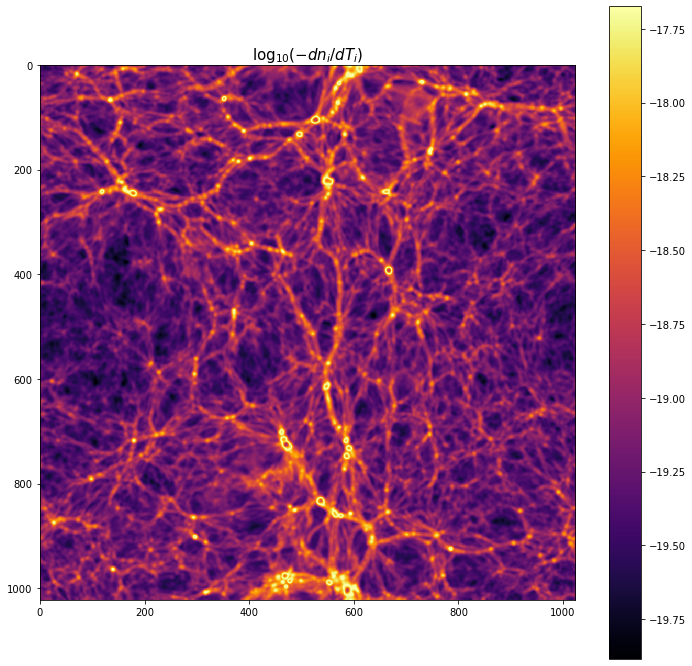

In [16]:
fig = plt.figure(figsize=(12,12))
plt.imshow(np.log10(dn_dr[0,:,:]), cmap='Blues')
plt.colorbar()
plt.title(r'$\log_{10}\left(dn_i / d\rho_i \right)$', fontsize=15)
plt.show()

fig = plt.figure(figsize=(12,12))
plt.imshow(np.log10(-dn_dt[0,:,:]), cmap='inferno')
plt.colorbar()
plt.title(r'$\log_{10}\left(-dn_i / dT_i \right)$', fontsize=15)
plt.show()

### test jacobian

In [ ]:
dn_dr_j = tape.jacobian(nhi.field, rhob.field)
dn_dr_j = tf.squeeze(dn_dr_j) # remove dims of size 1

# this prints a None gradient
# flat_nhi = tf.reshape(nhi.field, [1024**2])
# flat_rhob = tf.reshape(rhob.field, [1024**2])
# dn_dr_j = tape.jacobian(flat_nhi, rhob.field)

print(tf.shape(dn_dr_j))

## Look at the $\frac{\partial n_i}{\partial \rho_j}$ Jacobian

This should just be a diagonal line.

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.imshow(np.log10(dn_dr_j[...]), cmap='Blues')
plt.colorbar()
plt.title(r'log10($\partial n_i / \partial \rho_j$)')
plt.show()

## Compute $\tau_\text{real}$ and $\tau_\text{red}$ (one skewer)

In [24]:
# subsection shape
shape = [1, 1, 512]

rhob = snap.read_subfield(ds_path_rhob, shape)
temp = snap.read_subfield(ds_path_temp, shape)

# get the tau grids
with tf.GradientTape(persistent=True) as tape:
#     tape.watch(rhob.field)
#     tape.watch(temp.field)

    # number density
    nhi = lya_fields.set_nhi(snap, rhob, temp)
    
    # real-space tau
    vpara = grid.Grid(tf.zeros(rhob.shape, dtype='float64'), rhob.shape, rhob.size)
    tau_real = gmlt_spec_od_grid(snap.universe, snap.z, nhi.size,
            nhi.field, temp.field, vpara.field, nhi.field.shape[2])

    # redshift-space tau
    vpara = snap.read_subfield(ds_path_vz, shape)
    tau_red = gmlt_spec_od_grid(snap.universe, snap.z, nhi.size,
            nhi.field, temp.field, vpara.field, nhi.field.shape[2])

EOS duration: 6.323675632476807
tau duration: 0.9232439994812012
tau duration: 0.7605674266815186


## tape.gradient vs. tape.jacobian

The $i$th element in `tape.gradient(tau_real.field, rhob.field)` is the gradient of the sum of all $\tau$s with respect to $\rho_i$, which isn't what we want.

To get $\frac{\partial \tau_i}{\partial x_j}$ for every pair $i,j$, we need the Jacobian:

$${J} = {\begin{bmatrix}{\dfrac {\partial \tau_{1}}{\partial x_{1}}}&\cdots &{\dfrac {\partial \tau_{1}}{\partial x_{j}}}\\\vdots &\ddots &\vdots \\{\dfrac {\partial \tau_{i}}{\partial x_{1}}}&\cdots &{\dfrac {\partial \tau_{i}}{\partial x_{j}}}\end{bmatrix}}$$

## Look at the 4 Jacobians

In [18]:
# this works for a full skewer
dtreal_dr_j = tape.jacobian(tau_real.field, rhob.field)
dtred_dr_j = tape.jacobian(tau_red.field, rhob.field)

dtreal_dr_j = tf.squeeze(dtreal_dr_j)
dtred_dr_j = tf.squeeze(dtred_dr_j)

In [25]:
# the kernel restarts when this runs on a full skewer
# this runs on a half-skewer (512 cells), though
dtreal_dt_j = tape.jacobian(tau_real.field, temp.field)
dtred_dt_j = tape.jacobian(tau_red.field, temp.field)

dtreal_dt_j = tf.squeeze(dtreal_dt_j)
dtred_dt_j = tf.squeeze(dtred_dt_j)

In [ ]:
tf.shape(dtreal_dt_j)

### Look at the 4 $\frac{\partial \tau_i}{\partial x_j}$ fields (tape.jacobian)

In [32]:
print_minmax(dtreal_dt_j, 'dtreal_dt_j')

dtreal_dt_j min: -1.5774317302486286e-05
dtreal_dt_j max: 7.080119434563623e-06



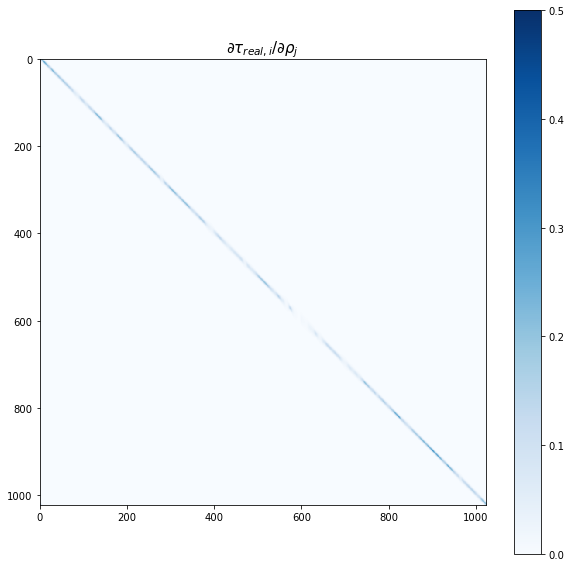

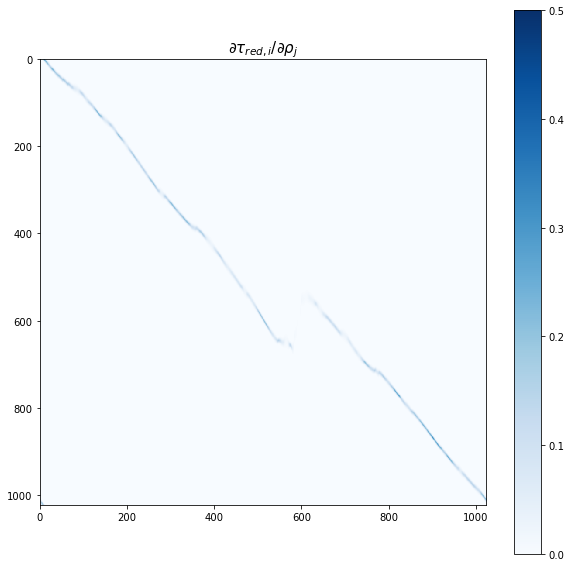

In [23]:
figsize=(10,10)

vmin_r = 0
vmax_r = 0.5

fig = plt.figure(figsize=figsize)
plt.imshow(dtreal_dr_j[:,:], cmap='Blues', vmin=vmin_r, vmax=vmax_r)
plt.colorbar()
plt.title(r'$\partial \tau_{real, i} / \partial \rho_j$', fontsize=15)
plt.show()

fig = plt.figure(figsize=figsize)
plt.imshow(dtred_dr_j[:,:], cmap='Blues', vmin=vmin_r, vmax=vmax_r)
plt.colorbar()
plt.title(r'$\partial \tau_{red, i} / \partial \rho_j$', fontsize=15)
plt.show()

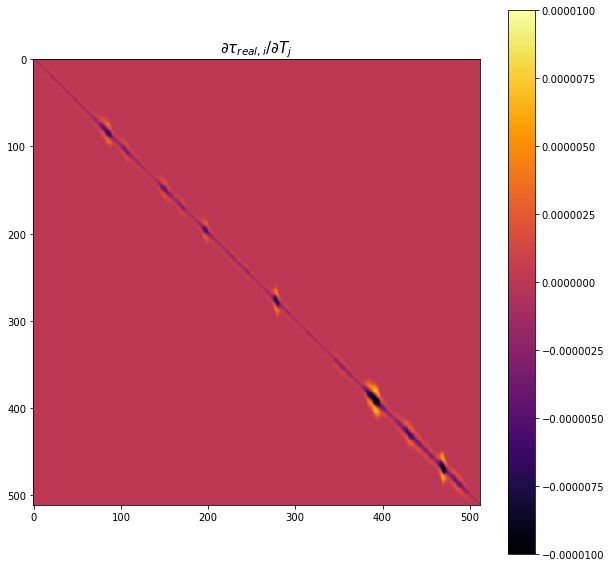

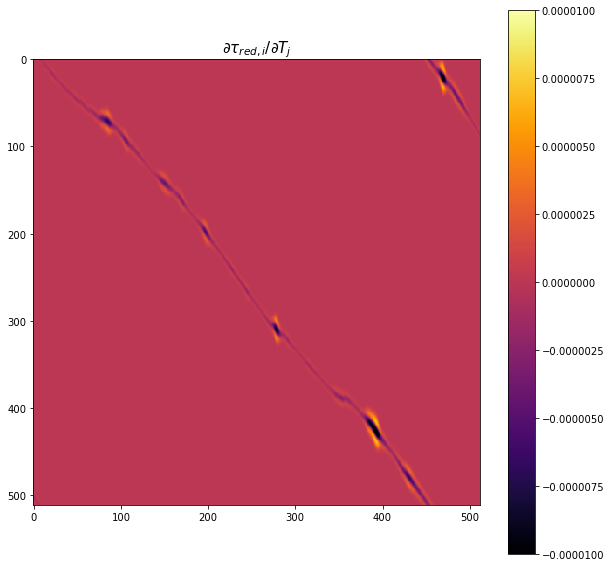

In [26]:
vmin_t = -1e-5
vmax_t = 1e-5

fig = plt.figure(figsize=figsize)
plt.imshow(dtreal_dt_j[:,:], cmap='inferno', vmin=vmin_t, vmax=vmax_t)
plt.colorbar()
plt.title(r'$\partial \tau_{real, i} / \partial T_j$', fontsize=15)
plt.show()

fig = plt.figure(figsize=figsize)
plt.imshow(dtred_dt_j[:,:], cmap='inferno', vmin=vmin_t, vmax=vmax_t)
plt.colorbar()
plt.title(r'$\partial \tau_{red, i} / \partial T_j$', fontsize=15)
plt.show()

# Jacobian examples

In [ ]:
# x = tf.linspace(-10.0, 10.0, 200+1)
# delta = tf.Variable(0.0)

# with tf.GradientTape() as tape:
#     y = tf.nn.sigmoid(x+delta)

# dy_dx = tape.jacobian(y, delta)

# plt.plot(x.numpy(), y, label='y')
# plt.plot(x.numpy(), dy_dx, label='dy/dx')
# plt.legend()
# _ = plt.xlabel('x')

[Define jacobian with tf.custom_gradient](https://stackoverflow.com/questions/66536946/define-jacobian-with-tensorflow-custom-gradient)

In [5]:
@tf.custom_gradient
def f(x):
    y = tf.stack([x[1], 2.0*x[0]])

    def grad(upstream):
        return tf.stack([2.0*upstream[1], upstream[0]])

    return y, grad

x = tf.Variable([1.0, 2.0])
with tf.GradientTape() as tape:
    y = f(x)
tape.jacobian(y, x)
#tape.gradient(y,x)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 0.]], dtype=float32)>

# Testing ndimage.zoom

In [37]:
import scipy

In [63]:
n_field = nhi.field.numpy()[0,0,:]
n_downsized = scipy.ndimage.zoom(n_field, 0.5)

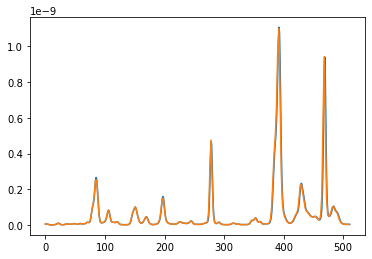

In [70]:
plt.plot(n_field)
plt.plot(np.arange(0, 512, 2), n_downsized)
plt.show()